In [1]:
#"Student ID": '21085920'
import nltk #import nltk library for preprocessing
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer # library for
import spacy # import spacy library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from collections import defaultdict
import copy
import re # import regular expression
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')
import csv
import math


# Filepath to your TSV file
file_path = 'Restaurant_Reviews.tsv'

# load data from file into an array list
data = []
with open(file_path, 'r') as file:
    tsv_reader = csv.reader(file, delimiter='\t')  # Specify tab delimiter
    for row in tsv_reader:
        data.append((row[0], row[1]))

data.remove(('Review', 'Liked'))# remove the data heading from the list

#Splitting the data set into train and test
from sklearn.model_selection import train_test_split
features = []
labels = []
for review in data:
    features.append(review[0])
    labels.append(review[1])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42) #split dataset into train and test data
train_data = [(x, y) for x, y in zip(x_train, y_train)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]
# print("Training Features:", x_train)
# print("Testing Features:", x_test)
# print("Training Labels:", y_train)
# print("Testing Labels:", y_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessing and Feature Extraction

In [2]:
#preprocess a specified text
#return the processed text as string
def preprocess(text):
  import string
  porter = PorterStemmer()
  #remove stop words
  stop_words = set(stopwords.words('english'))
  #removes all form of punctautationi
  cleaned_text = re.sub(r'[^\w\s]', '', text)  # This removes all punctuations and non-numeric characters
#   cleaned_text = cleaned_text.replace('...', '') # Specifically remove ellipsis
  words = nltk.word_tokenize(cleaned_text)#tokenize text
  words = [word.lower() for word in words if word.lower() not in stop_words] #lower case each word
  words = [word for word in words if word not in string.punctuation]#removing punctuations
  # Initialize the lemmatizer
  # lemmatizer = WordNetLemmatizer()
  # words = [lemmatizer.lemmatize(word) for word in words]
  text = ' '.join(words) #joins all words from the word list

  words = nlp(text)  #process the text with spacy
  words  = [token.lemma_ for token in words] #lemmatize each word
  text = ' '.join(words) #joins all elements words list

  return  text

In [3]:
#Calcuates the prior probability of the class
#calculates the term frequency of each word
#returns the the prior probability and term frequency
def review_prob(data):
    prior = defaultdict(int)
    frequency = defaultdict(lambda: defaultdict(int))
    for review, label in data:
        prior[label] += 1
        words = preprocess(review).split()
        for word in words:
            frequency[label][word] += 1
    total_reviews = len(data)
    for label in prior:
        prior[label] /= total_reviews
    return prior, frequency


In [4]:
#reivew - new review
#prior_prob - prior probability
#frequency - term frequency of each word in the doc
#return the class of a review
def classify_review(review, prior_prob, frequency):
    words = preprocess(review).split()
    posteriors = {}
    prob_positive = []
    prob_negative = []
    alpha = 1

    for label in prior_prob:
        class_size = sum(frequency[label].values())
        unique_words = len(frequency[label])
        posterior = prior_prob[label]
        log_posterior = math.log10(posterior)
        for word in words:
            #appying laplacing smoothing
            prob = (frequency[label].get(word, 0) + alpha) / (class_size + (unique_words  * alpha))
            if label == '1':
                prob_positive.append(prob)
            elif label == '0':
                prob_negative.append(prob)
            posterior *= prob
        posteriors[label] = posterior
    #calcuate log_likelihood
    for pos, neg in zip(prob_positive, prob_negative):
        log_posterior += math.log10(pos/neg)
    return max(posteriors, key=posteriors.get), log_posterior



In [5]:
prior_prob, frequency = review_prob(train_data)
predictions = []
for count, review in enumerate(test_data, start=1):
    result = classify_review(review[0], prior_prob, frequency)
    prediction = '1'
    if result[1] <= 0:
        prediction = '0'
    predictions.append(int(prediction))
    print(f'{count}. {review[0]} - {prediction}')

1. If you haven't gone here GO NOW! - 0
2. Try them in the airport to experience some tasty food and speedy, friendly service. - 1
3. The restaurant is very clean and has a family restaurant feel to it. - 1
4. I personally love the hummus, pita, baklava, falafels and Baba Ganoush (it's amazing what they do with eggplant!). - 1
5. Come hungry, leave happy and stuffed! - 1
6. It's a great place and I highly recommend it. - 1
7. Best of luck to the rude and non-customer service focused new management. - 0
8. Reasonably priced also! - 1
9. Worst food/service I've had in a while. - 0
10. I had a seriously solid breakfast here. - 1
11. The service was terrible though. - 0
12. 2 times - Very Bad Customer Service ! - 0
13. Tried to go here for lunch and it was a madhouse. - 0
14. The food wasn't good. - 0
15. The meat was pretty dry, I had the sliced brisket and pulled pork. - 0
16. Overall, a great experience. - 1
17. I went to Bachi Burger on a friend's recommendation and was not disappointe

Evaluation

In [6]:
test_truth = [int(review[1]) for review in test_data]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Basic metrics
accuracy = accuracy_score(test_truth, predictions)
precision = precision_score(test_truth, predictions)
recall = recall_score(test_truth, predictions)
f1 = f1_score(test_truth, predictions)

# Confusion matrix
conf_matrix = confusion_matrix(test_truth, predictions)
# Summary report
report = classification_report(test_truth, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", report)


Accuracy: 0.74
Precision: 0.8023255813953488
Recall: 0.6634615384615384
F1 Score: 0.7263157894736842
Confusion Matrix:
 [[79 17]
 [35 69]]


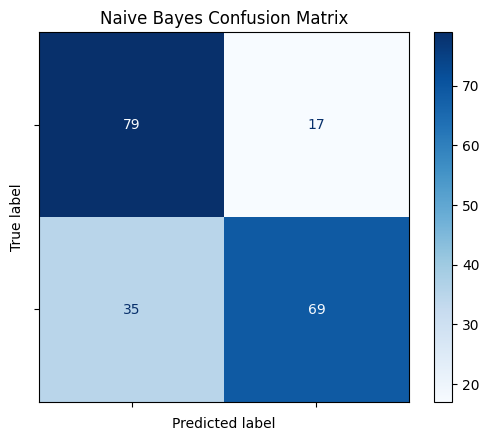

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels='')
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [8]:
import pandas as pd
# Filepath to your TSV file
file_path = 'Restaurant_Reviews.tsv'
# Reading TSV into a DataFrame and then converting to a list
df = pd.read_csv(file_path, sep='\t',
  converters = {
      'Column1': str.strip,
      'Column2': str.strip,
  })  # Specify tab separator
data = df.values.tolist()  # Convert DataFrame to a list of lists

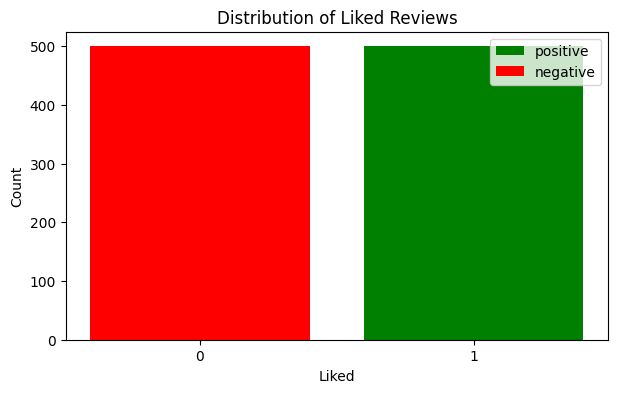

In [9]:
import matplotlib.pyplot as plt
result = df['Liked'].value_counts()
result = result.reset_index()

plt.figure(figsize=(7, 4))
plt.bar(result['Liked'], result['count'], color=['green', 'red'], label=['positive', 'negative'])
plt.title('Distribution of Liked Reviews')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.legend()
plt.xticks(result['Liked'])  # Set x-ticks to match the "Liked" values (0 and 1)
plt.show()

Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

x = df['Review']
y = df['Liked']
vectorizer = TfidfVectorizer()
x_transformed  = vectorizer.fit_transform(df['Review'])
x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.2, random_state=42)
import pandas as pd
from sklearn.model_selection import train_test_split
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [11]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)
# Calculate accuracy
accuracy = accuracy_score (y_test , y_pred )
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print (f" Accuracy : { accuracy }")
print (f" Precision : { precision }")
print (f" Recall : { recall }")
print (f" F1 Score : { f1 }")

# Confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred)
# print(f'confusion matrix: \n{conf_matrix2}')

 Accuracy : 0.81
 Precision : 0.875
 Recall : 0.7403846153846154
 F1 Score : 0.8020833333333334


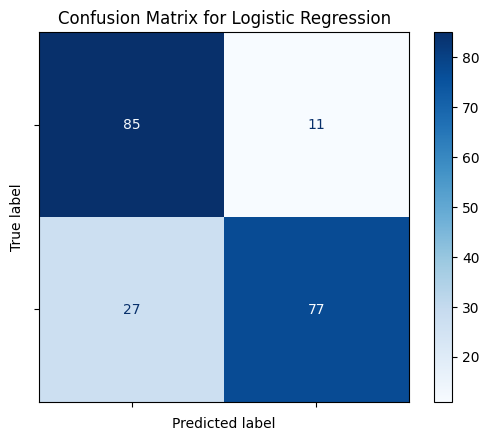

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels='')
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Neutral Sentiment Analysis

In [32]:
def predict_review_advanced(review):
    review_transformed = vectorizer.transform([review])
    prediction = model.predict(review_transformed)
    prediction_prob = model.predict_proba(review_transformed)

    conf = max(prediction_prob[0])
    if conf > 0.69:
        if prediction[0] == 1:
            print("Positive Review", conf)
        else:
            print("Negative Review", conf)
    else:
        print("Neutral Review", conf)

In [34]:
review = 'poor experience'
predict_review_advanced(review)

Neutral Review 0.5410431057831979


Aspect Based Sentiment Analysis

In [15]:
#Advanced predicition with Logisitic Regression
import json

# Step 1: Load the JSONL file into a pandas DataFrame
def jsonl_to_dataframe(jsonl_file):
    data = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            entry = json.loads(line)
            text = entry['text']
            for label in entry['labels']:
                aspect = label['aspect']
                opinion = label['opinion']
                polarity = label['polarity']
                data.append({
                    'text': text,
                    'aspect': aspect,
                    'opinion': opinion,
                    'polarity': polarity
                })
    return pd.DataFrame(data)

# Parse the training JSONL file into a DataFrame
# Replace 'train_dataset.jsonl' with the path to your training JSONL file
train_dataframe = jsonl_to_dataframe('train.jsonl')
print("Parsed Training DataFrame:")
print(train_dataframe.head())

# Drop rows with NaN values
train_dataframe.dropna(inplace=True)

# Map polarity to binary labels ('positive' -> 1, 'negative' -> 0)
train_dataframe['label'] = train_dataframe['polarity'].map({'positive': 1, 'negative': 0})

# Ensure no NaN values remain in the label column
train_dataframe = train_dataframe[train_dataframe['label'].notna()]

# Combine aspect and opinion for input features
train_dataframe['features'] = train_dataframe['aspect'] + ' ' + train_dataframe['opinion']

# Vectorize the text using TF-IDF for training data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_dataframe['features'])
y_train = train_dataframe['label']

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Replace 'test_dataset.jsonl' with the path to your test JSONL file
test_dataframe = jsonl_to_dataframe('test.jsonl')
print("Parsed Test DataFrame:")
print(test_dataframe.head())

# Drop rows with NaN values
test_dataframe.dropna(inplace=True)

# Map polarity to binary labels ('positive' -> 1, 'negative' -> 0)
test_dataframe['label'] = test_dataframe['polarity'].map({'positive': 1, 'negative': 0})

# Ensure no NaN values remain in the label column
test_dataframe = test_dataframe[test_dataframe['label'].notna()]

# Combine aspect and opinion for input features
test_dataframe['features'] = test_dataframe['aspect'] + ' ' + test_dataframe['opinion']

#Vectorize the text using the same TF-IDF vectorizer for test data
X_test = vectorizer.transform(test_dataframe['features'])
y_test = test_dataframe['label']

#Evaluate the model on the test data
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Parsed Training DataFrame:
                                                text  \
0              But the staff was so horrible to us .   
1  To be completely fair , the only redeeming fac...   
2  The food is uniformly exceptional , with a ver...   
3  The food is uniformly exceptional , with a ver...   
4  Our agreed favorite is the orrechiete with sau...   

                                aspect        opinion  polarity  
0                                staff       horrible  negative  
1                                 food  above average  positive  
2                                 food    exceptional  positive  
3                              kitchen        capable  positive  
4  orrechiete with sausage and chicken       favorite  positive  
Parsed Test DataFrame:
                                                text          aspect  \
0                   The bread is top notch as well .           bread   
1  I have to say they have one of the fastest del...  delivery times   
2